In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername of the unzipped folder
FOLDERNAME = 'unet-master'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# %cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME
#!pip install
#4/1AY0e-g5h4eZedG3k6mfdIj0OYbR717PFyEhKuxK5PidsrBbPRxi8fge6E3c

Mounted at /content/drive
/content/drive/My Drive/unet-master


In [7]:
#You need to make sure plantcv is installed so you can access its useful prune feature

In [2]:
pip install plantcv

In [4]:
from skimage import data, io, filters, morphology, color, transform
from skimage.util import invert, img_as_ubyte, compare_images
from skimage.measure import label
from skimage.color import label2rgb
from skimage.metrics import adapted_rand_error
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from plantcv import plantcv as pcv

In [5]:
def clean_tracing(tracing, verbose):
  
  if tracing.shape[2] == 4: #RBGA images are shape: h,w,4. They need to be turned into RGB:
    tracing = color.rgba2rgb(tracing)

  #We should only have RGB images at this point

  #First: remove any red pixels (the little numbers inside the grains) 
  #create mask which is True for red pixels
  mask = (tracing == [255, 0, 0]).all(axis=2)
  #Apply mask, turning red pixels white to erase the little numbers
  tracing[mask] = [255,255,255]

  #Then: Convert image to grayscale and then binary using a threshold
  tracing = color.rgb2gray(tracing)
  thresh = 254/255
  threshold = np.zeros(tracing.shape)
  threshold[tracing <= thresh] = 1

  #Step 0: Optional systematic rotate
  rotated = transform.rotate(threshold,90,resize=True,preserve_range=True)
  
  #Step 1: Dilate
  k = 2 #define the number of dilations
  dilated = rotated
  for i in range(k):
    dilated = morphology.dilation(dilated)
  
  #Step 2: Skeletonize
  skeleton = pcv.morphology.skeletonize(mask=dilated)

  #Step 3: Prune
  
  # Set global debug behavior to None (default), "print" (to file), 
  # or "plot" (Jupyter Notebooks or X11)
  pcv.params.debug = None

  # Remove all spurs below length size
  size = 20
  pruned_skeleton, segmented_img, segment_objects = pcv.morphology.prune(skeleton, size)

  #Step 4: Dilate
  k = 1 #define the number of dilations
  redilated = pruned_skeleton
  for i in range(k):
    redilated = morphology.dilation(redilated)

  def imsubplot(ax, im, cmap="gray", title=None):
    ax.imshow(im, cmap=cmap)
    ax.axis("off")
    if title:
        ax.set_title(title)

  if verbose:
    fig, (a, b, c, d, e) = plt.subplots(ncols=5, figsize=(25,5))
    
    h1,h2,w1,w2 = (2350,2500,4250,4400)

    imsubplot(a, rotated[h1:h2,w1:w2], title='Raw')
    imsubplot(b, dilated[h1:h2,w1:w2], title='Dilated')
    imsubplot(c, skeleton[h1:h2,w1:w2], title='Skeleton')
    imsubplot(d, pruned_skeleton[h1:h2,w1:w2], title ='Pruned')
    imsubplot(e, redilated[h1:h2,w1:w2], title = 'Redilated')
    plt.show()
    return redilated
  else:
    return redilated

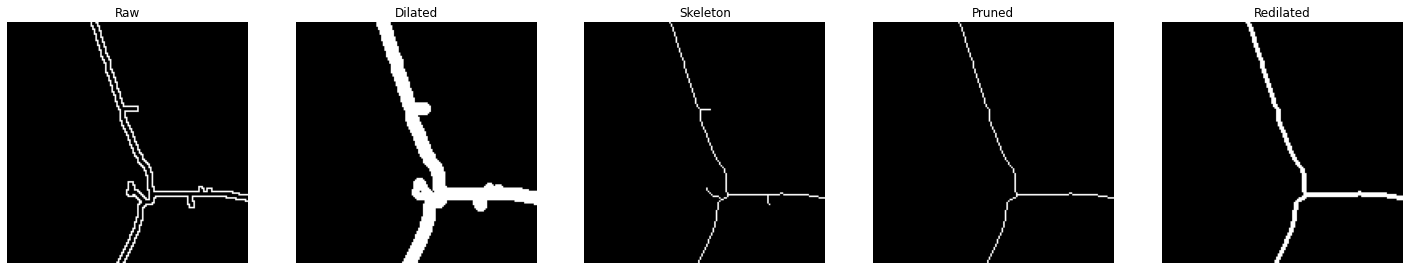

In [6]:
#Here's a sample visual of what the processing does on a raw tracing
test_dir = 'trace_processing/'
tracing = io.imread(f'{test_dir}2114_trace_raw.gif')

clean = clean_tracing(tracing, verbose=True)

In [22]:
#This cell lets you run a loop to process all images in one folder (path), and output them to a new folder (outPath)

import os

path = 'trace_processing/Tracings 10HR/'
outPath = 'trace_processing/Cleaned 10HR/'

# iterate through the names of contents of the folder
for image_path in os.listdir(path):

    # create the full input path and read the file
    input_path = os.path.join(path, image_path)

    tracing = io.imread(input_path)

    clean = clean_tracing(tracing, verbose=False)
    new_clean  = invert(clean) #Since we want white grain / black boundary, invert

    fullpath = os.path.join(outPath, 'trace_new_clean_'+image_path[:-4]+'.png') #modify this to suit your needs
    io.imsave(fullpath,new_clean)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: trace_processing/Cleaned 10HR/trace_new_clean_Drawing of 10hr2153.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: trace_processing/Cleaned 10HR/trace_new_clean_Drawing of 10hr2155.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: trace_processing/Cleaned 10HR/trace_new_clean_Drawing of 10hr2426.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: trace_processing/Cleaned 10HR/trace_new_clean_Drawing of 10hr2400.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: trace_processing/Cleaned 10HR/trace_new_clean_Drawing of 10hr2159.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: trace_processing/Cleaned 10HR/trace_new_clean_Drawing of 10hr2